# Hidden Markov Models

In [1]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from scipy.stats import norm

Hideen Markov models (HMMs) are a particular king of graphical model for dependence in data and may be viewed as in the figure below:
![HMM_graphical_model](./HMM_graphical_model.png)

Here, $X_1,X_2,\dots$ are the random variables (r.v.s) corresponding to obervables, while $Y_1,Y_2,\dots$ are r.v.s corresponding to hidden (or latent) variables that modulate $X$. 

More specifically, $Y$ is a finite state Markov chain taking values in $\{1,\dots,K\}$ with transition probability matrix 
$$
A_{ij}=\mathbb{P}(Y_{t+1}=j|Y_t=i)
$$
and, we assume that $X$ are conditionally Gaussian,
$$
X_t|_{Y_t=k}\sim\mathcal{N}(\mu_k,\sigma_k^2)
$$
where $\mu_k$ and $\sigma_k^2$ are the conditional mean and variance, respectively, conditioned on $Y_t=k$.

# Simulate some data from an HMM

In [2]:
def SimData(pi, A, mu, sigma, Nsims, Nsteps):
    
    Y = np.zeros((Nsims,Nsteps)).astype(int)
    X = np.zeros((Nsims,Nsteps))
    
    cs_A = np.cumsum(A,axis=1)
    cs_pi = np.cumsum(pi)
    
    # draw from the prior
    for i in range(Nsims):
        Y[i,0] = np.sum(np.random.rand() > cs_pi)
        
    for t in range(Nsteps):

        # generate X
        X[:,t] = mu[Y[:,t]] + sigma[Y[:,t]] * np.random.randn(Nsims)
        
        # update Y
        if t < Nsteps-1:
            # generate uniforms and duplicate across columns
            U = np.matlib.repmat(np.random.rand(Nsims,1),1,pi.shape[0])
            
            # update Y by selecting appropriate row and summing number of times 
            # that row crosses a threshold
            Y[:,t+1] = np.sum(U > cs_A[Y[:,t],:], axis=1)
        
    return X.T, Y

In [3]:
# Let's sim some data
pi = np.array([0.3, 0.7])
A = np.array([[0.8, 0.2],[0.4,0.6]])
mu = np.array([-1,  1])
sigma = np.array([1,2])

X, Y = SimData(pi, A, mu, sigma, 50, 100) 

### Plot a few of the sample series

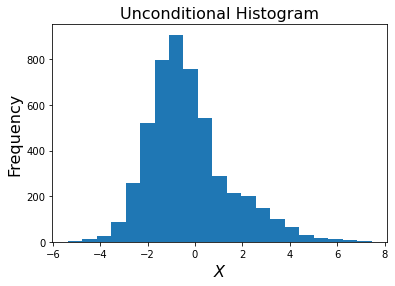

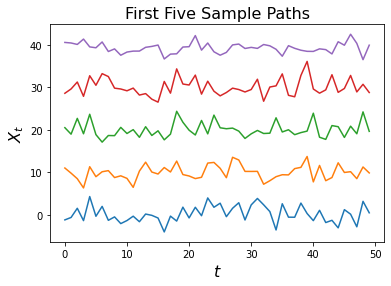

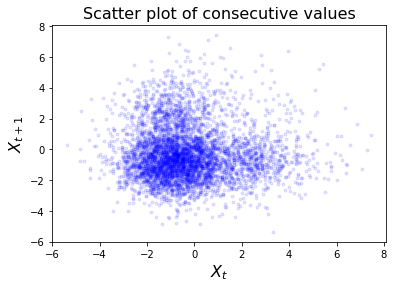

In [4]:
plt.hist(X.flatten(),bins=21)

plt.title('Unconditional Histogram', fontsize=16)
plt.xlabel(r"$X$", fontsize=16)
plt.ylabel(r"Frequency", fontsize=16)

plt.show()

for i in range(5):
    plt.plot(i*10+X[i,:])

plt.title('First Five Sample Paths', fontsize=16)
plt.xlabel(r"$t$", fontsize=16)
plt.ylabel(r"$X_t$", fontsize=16)

plt.show()


for i in range(X.shape[0]):
    plt.plot(X[i,:-1], X[i,1:],'.',alpha=0.1, color='b')
    
plt.xlabel(r"$X_{t}$", fontsize=16)
plt.ylabel(r"$X_{t+1}$", fontsize=16)    
plt.title('Scatter plot of consecutive values', fontsize=16)

plt.show()

# Expectation-Maxmisation Algorithm
In this section, we implement the expectation-maximisation (EM) algorithm from scratch, with using only the basic numpy package and standard normal pdfs.

The general algorithm is below

<img src="EM_algo.png" alt="EM_Algo" width="50%"/>

$\psi_i(x;\theta)$ represents the emission probability, and for the specific Gaussian HMM, the update rules become

$$
\mu_i=\frac{\sum_{t} x_t\,\gamma_{t,i}}{\sum_{t}\gamma_{t,i}}
$$
and
$$
\sigma_i^2=\frac{\sum_{t} (x_t-\mu_i)^2\,\gamma_{t,i}}{\sum_{t}\gamma_{t,i}}
$$

In [5]:
# emission probability for a single data point
def psi(x, mu, sigma):
    
    return np.exp(-0.5* ((x-mu)/sigma)**2 ) / (np.sqrt(2*np.pi)*sigma)

# compute the filter for a single trajectory
def forwardFilter(X, pi, A, mu, sigma):

    K = pi.shape[0]
    N = X.shape[0]
        
    alpha = np.zeros((K,N))
    eta = np.zeros(N)
    
    # initialize filter
    alpha[:,0] = psi(X[0], mu, sigma) * pi

    eta[0] = np.sum(alpha[:,0])        
    alpha[:,0] /= eta[0]
    
    # step forward in time    
    for t in range(1,N):
        
        alpha[:,t] = psi(X[t], mu, sigma) * np.matmul( A.T,alpha[:,t-1] )
    
        eta[t] = np.sum(alpha[:,t])
        alpha[:,t] /= eta[t]
    
    return eta, alpha

# backward filter
def backwardFilter(X, eta, pi, A, mu, sigma):
    
    K = pi.shape[0]
    N = X.shape[0]
    
    beta = np.zeros((K,N))
    
    beta[:,-1] = 1
    
    for t in range(N-2,-1,-1):
        beta[:,t] = np.matmul(A, beta[:,t+1] * psi(X[t+1],mu,sigma) ) / eta[t+1]
        
    return beta

#perform the e-step
def estep(X, pi, A, mu, sigma):
    
    K = pi.shape[0]
    
    alpha = np.zeros((K, X.shape[0],X.shape[1]))
    beta = np.zeros((K, X.shape[0],X.shape[1]))
    gamma = np.zeros((K, X.shape[0],X.shape[1]))
    xi = np.zeros((K, K, X.shape[0]-1,X.shape[1]))
    eta = np.zeros((X.shape[0],X.shape[1]))
    
    # repeat for each "replica"
    for m in range(X.shape[1]):
        
        eta[:,m], alpha[:,:,m] = forwardFilter(X[:,m], pi, A, mu, sigma)
        
        beta[:,:,m] = backwardFilter(X[:,m], eta[:,m], pi, A, mu, sigma)
        
        gamma[:,:,m] = alpha[:,:,m] * beta[:,:,m]
        
        for i in range(K):
            for j in range(K):
                xi[i,j,:,m] = alpha[i,:-1,m] * A[i,j] * psi(X[1:,m], mu[j], sigma[j]) * beta[j,1:,m] / eta[1:,m]

    return eta, gamma, xi        

# perform m-step
def mstep(X, gamma, xi):
    
    K = gamma.shape[0]
    
    # update pi
    pi = np.sum(gamma[:,0,:],axis=1)
    pi /= np.sum(pi)
    
    # update A 
    A = np.zeros((K,K))
    mu = np.zeros(K)    
    sigma = np.zeros(K)
    
    for i in range(K):
        
        nrm_fac = np.sum(gamma[i,:,:], axis = None)

        mu[i] = np.sum(gamma[i,:,:] * X, axis = None)/nrm_fac
        sigma[i] = np.sqrt(np.sum(gamma[i,:,:] * (X-mu[i])**2, axis = None) / nrm_fac)
        
        for j in range(K):
            A[i,j] = np.sum(xi[i,j,:,:], axis=None) / np.sum(gamma[i,:-1,:], axis=None)


    return pi, A, mu, sigma

# for generating an initial guess
def InitialParamGuess(X, K):
    
    mu = np.mean(X)
    sigma = np.std(X)
    
    # add some noise
    epsilon = 0.2
    mu *= np.sort(np.exp(epsilon * np.random.randn(K)))
    sigma *= np.sort(np.exp(epsilon * np.random.randn(K)))

    pi = np.ones(K) / K
    pi *= np.exp(epsilon * np.random.randn(K))
    pi /= np.sum(pi)
    
    A = np.ones((K,K)) / K
    for i in range(K):
        
        A[i,:] *= np.exp(epsilon * np.random.randn(K))
        A[i,:] /= np.sum(A[i,:])

    return pi, A, mu, sigma

# perform the EM
def EM(X, MAX_ITER, tol, K):
    
    pi0, A0, mu0, sigma0 = InitialParamGuess(X, K)
    
    pi = []
    A = []
    mu = []
    sigma = []
    ell = [] # log-likelihood
    
    pi.append(pi0)
    A.append(A0)
    mu.append(mu0)
    sigma.append(sigma0)
    
    
    for i in range(MAX_ITER):
          
        # perform e-step
        eta, gamma, xi = estep(X, pi[i], A[i], mu[i], sigma[i])
        
        ell.append(np.sum(np.log(eta),axis=None))
        
        # peform m-step
        pi_new , A_new, mu_new, sigma_new = mstep(X, gamma, xi)
        
        # store results
        pi.append(pi_new)
        A.append(A_new)
        mu.append(mu_new)
        sigma.append(sigma_new)        
        
        if (i%10) ==0:
            
            print('iter = ' + str(i))
            print(ell[-1])
            print(np.abs(ell[i]/ell[i-1]-1))
            print(pi_new)
            print(A_new)
            print(mu_new)
            print(sigma_new)
            
            print("***")
            
        if i > 10:
            if np.abs(ell[i]/ell[i-1]-1)<tol:
                break
        
    ell.append(np.sum(np.log(eta),axis=None))
            
    return pi, A, mu, sigma, ell

In [6]:
pi_est, A_est, mu_est, sigma_est, ell = EM(X, 500, 1e-9, 2)

iter = 0
-10013.367512182394
0.0
[0.43224968 0.56775032]
[[0.46353083 0.53646917]
 [0.45005458 0.54994542]]
[-0.48640731 -0.11238346]
[1.28239109 1.99172855]
***
iter = 10
-9377.957212402644
0.0004180059228175992
[0.24971229 0.75028771]
[[0.68404653 0.31595347]
 [0.43298646 0.56701354]]
[-1.00180407  0.68449581]
[0.93267888 2.02506165]
***
iter = 20
-9365.953021581594
2.9162476159916295e-05
[0.30265726 0.69734274]
[[0.74675779 0.25324221]
 [0.40936427 0.59063573]]
[-0.99282796  0.84155901]
[0.97130745 2.01168516]
***
iter = 30
-9365.057725329425
2.9072577982791614e-06
[0.32657089 0.67342911]
[[0.76051538 0.23948462]
 [0.41224506 0.58775494]]
[-0.98581674  0.90265636]
[0.98614913 2.00675079]
***
iter = 40
-9364.943680497863
5.05451120069722e-07
[0.33531143 0.66468857]
[[0.7641808 0.2358192]
 [0.4164491 0.5835509]]
[-0.98356776  0.92955262]
[0.99168123 2.00343155]
***
iter = 50
-9364.921622918355
1.0720923215856715e-07
[0.33902431 0.66097569]
[[0.76545862 0.23454138]
 [0.41890752 0.58109

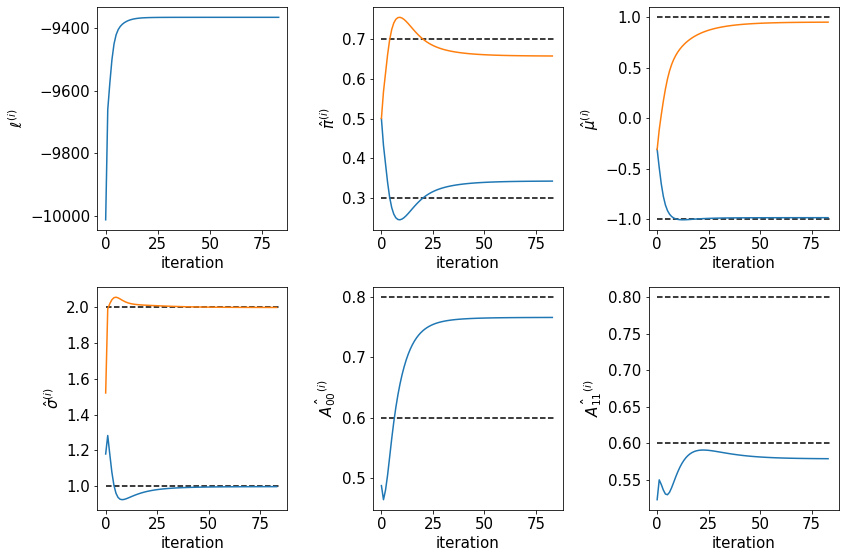

In [7]:
plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 15})
plt.subplots_adjust(wspace =0.5)

plt.subplot(2,3,1)
plt.plot(ell)
plt.xlabel('iteration')
plt.ylabel('$\ell^{(i)}$')

plt.subplot(2,3,2)
plt.plot(pi_est)
plt.hlines(pi,0, len(ell),linestyles='dashed')
plt.xlabel('iteration')
plt.ylabel('$\hat{\pi}^{(i)}$')

plt.subplot(2,3,3)
plt.plot(mu_est)
plt.hlines(mu,0, len(ell),linestyles='dashed')
plt.xlabel('iteration')
plt.ylabel('$\hat{\mu}^{(i)}$')

plt.subplot(2,3,4)
plt.plot(sigma_est)
plt.hlines(sigma,0, len(ell),linestyles='dashed')
plt.xlabel('iteration')
plt.ylabel('$\hat{\sigma}^{(i)}$')


plt.subplot(2,3,5)
plt.plot(np.array(A_est)[:,0,0])
plt.hlines(A[0,0],0, len(ell),linestyles='dashed')
plt.hlines(A[1,1],0, len(ell),linestyles='dashed')
plt.xlabel('iteration')
plt.ylabel('$\hat{A_{00}}^{(i)}$')


plt.subplot(2,3,6)
plt.plot(np.array(A_est)[:,1,1])
plt.hlines(A[0,0],0, len(ell),linestyles='dashed')
plt.hlines(A[1,1],0, len(ell),linestyles='dashed')
plt.xlabel('iteration')
plt.ylabel('$\hat{A_{11}}^{(i)}$')

plt.tight_layout()
plt.show()

In [10]:
A_est

[array([[0.48689547, 0.51310453],
        [0.47717734, 0.52282266]]),
 array([[0.46353083, 0.53646917],
        [0.45005458, 0.54994542]]),
 array([[0.47953726, 0.52046274],
        [0.45636316, 0.54363684]]),
 array([[0.50449224, 0.49550776],
        [0.4639625 , 0.5360375 ]]),
 array([[0.53452584, 0.46547416],
        [0.46941675, 0.53058325]]),
 array([[0.56485834, 0.43514166],
        [0.47041564, 0.52958436]]),
 array([[0.5925494, 0.4074506],
        [0.4670804, 0.5329196]]),
 array([[0.61672119, 0.38327881],
        [0.46094211, 0.53905789]]),
 array([[0.63753162, 0.36246838],
        [0.45359061, 0.54640939]]),
 array([[0.65541767, 0.34458233],
        [0.44612676, 0.55387324]]),
 array([[0.67080463, 0.32919537],
        [0.4391646 , 0.5608354 ]]),
 array([[0.68404653, 0.31595347],
        [0.43298646, 0.56701354]]),
 array([[0.69543543, 0.30456457],
        [0.42768177, 0.57231823]]),
 array([[0.70521898, 0.29478102],
        [0.42323775, 0.57676225]]),
 array([[0.71361247, 0.2